# Tutorial: DataFrames with RLM

DSPy provides first-class support for pandas DataFrames in the RLM (Recursive Language Model) module. DataFrames are automatically serialized via Parquet format, preserving dtypes, and rich metadata is provided to the LLM.

> **Important**: `dspy.DataFrame` should only be used with `dspy.RLM`. Other modules like `ChainOfThought` or `Predict` will only see a string representation of the DataFrame, not the actual data. RLM provides a Python sandbox where the DataFrame is available for code execution.

Install the latest DSPy via `pip install -U dspy` and follow along.

## 1) Setup

First, let's configure DSPy with an LM and create a sample DataFrame.

In [ ]:
import warnings
warnings.filterwarnings("ignore", message="Pydantic serializer warnings")

import dspy
import pandas as pd

# Configure your LM
lm = dspy.LM("anthropic/claude-sonnet-4-5-20250929", max_tokens=16000)
dspy.configure(lm=lm)

In [5]:
# Create a sample DataFrame
dataframe = pd.DataFrame({
    "name": ["Alice", "Bob", "Charlie", "David", "Eve"],
    "age": [25, 30, 35, 40, 45],
    "city": ["New York", "Los Angeles", "Chicago", "Houston", "Miami"]
})

dataframe

,name,age,city
0,Alice,25,New York
1,Bob,30,Los Angeles
2,Charlie,35,Chicago
3,David,40,Houston
4,Eve,45,Miami


## 2) Using `dspy.DataFrame` in Signatures

To use a DataFrame as an input field in a DSPy Signature, use the `dspy.DataFrame` type annotation. This tells Pydantic how to handle the DataFrame type.

In [6]:
class DocWriter(dspy.Signature):
    """Write documentation for the provided data."""
    
    dataframe: dspy.DataFrame = dspy.InputField()
    documentation: str = dspy.OutputField(desc="Generated markdown documentation.")

## 3) Running RLM with DataFrames

Now we can use `dspy.RLM` to process the DataFrame. The RLM module will:

1. Serialize the DataFrame to Parquet format (preserving dtypes)
2. Provide rich metadata to the LLM (shape, columns, dtypes, sample rows)
3. Make the DataFrame available in the Python sandbox for code execution

In [7]:
doc_writer = dspy.RLM(
    DocWriter,
    max_iterations=10,
    verbose=True
)

result = doc_writer(dataframe=dataframe)

2026/01/26 17:11:37 INFO dspy.predict.rlm: RLM iteration 1/10
Reasoning: I need to create documentation for the provided dataframe. Let me start by exploring the data to understand its structure and content fully before generating documentation.

From the preview, I can see:
- 5 rows total
- 3 columns: name (object/string), age (int64), city (object/string)
- Sample data shows names, ages, and cities

My approach:
1. First, explore the full dataframe to see all rows and understand the data better
2. Gather statistics and metadata about the dataframe
3. Generate comprehensive documentation based on the exploration
4. Submit the documentation

Let me start by examining the complete dataset.
Code:
```python
import pandas as pd

# Examine the full dataframe
print("Full DataFrame:")
print(dataframe)
print("\n" + "="*60 + "\n")

# Get basic info
print("DataFrame Info:")
print(f"Shape: {dataframe.shape}")
print(f"Columns: {list(dataframe.columns)}")
print(f"Data types:\n{dataframe.dtypes}")
p

In [8]:
from IPython.display import Markdown, display
display(Markdown(result.documentation))

# Dataset Documentation

## Overview
This dataset contains information about 5 individuals, including their names, ages, and cities of residence.

## Dataset Structure
- **Total Rows**: 5
- **Total Columns**: 3
- **Memory Usage**: 0.8 KB
- **Missing Values**: None

## Column Descriptions

### 1. name (object/string)
- **Description**: The name of each individual
- **Data Type**: Object (string)
- **Unique Values**: 5 (all unique)
- **Sample Values**: Alice, Bob, Charlie, David, Eve

### 2. age (int64)
- **Description**: The age of each individual in years
- **Data Type**: Integer (int64)
- **Range**: 25 to 45 years
- **Mean**: 35.0 years
- **Standard Deviation**: 7.91 years
- **Distribution**: 25, 30, 35, 40, 45 (evenly spaced, increments of 5 years)

### 3. city (object/string)
- **Description**: The city where each individual resides
- **Data Type**: Object (string)
- **Unique Values**: 5 (all unique)
- **Cities**: New York, Los Angeles, Chicago, Houston, Miami

## Data Quality
- **Completeness**: 100% - No missing values in any column
- **Uniqueness**: All names and cities are unique across the dataset
- **Consistency**: Age values follow a consistent pattern (5-year intervals)

## Sample Data
```
     name  age         city
0   Alice   25     New York
1     Bob   30  Los Angeles
2 Charlie   35      Chicago
3   David   40      Houston
4     Eve   45        Miami
```

## Potential Use Cases
- Demographic analysis
- Geographic distribution studies
- Age-related pattern analysis
- Small-scale testing and prototyping
- Educational examples for data analysis

## Notes
- This is a small, clean dataset suitable for demonstration or testing purposes
- All entries represent distinct individuals with no duplicates
- Ages are distributed evenly across a 20-year span


## 4) How It Works

When you pass a DataFrame to RLM:

1. **Serialization**: The DataFrame is serialized to Parquet format using PyArrow, which preserves data types (int, float, datetime, categorical, etc.)

2. **Metadata**: The LLM receives rich metadata about the DataFrame:
   - Shape (rows x columns)
   - Column names and dtypes
   - Null value counts
   - Sample rows (first and last 3 rows)

3. **Sandbox Access**: The DataFrame is made available in the Python sandbox, where the LLM-generated code can access it directly using pandas operations.

## 5) Advanced Example: Data Analysis

Let's try a more complex example where the LLM analyzes the data from the UCI Adult / Census Income dataset.

In [9]:
import pandas as pd

input_data = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
    header=None
)

In [17]:
from typing import Optional, List

class DataAnalyst(dspy.Signature):
    """Analyze the data and provide insights. Do just a very basic analysis, nothing substantial. When generating images, do this using in-memory IO operations and return them as base64-encoded strings."""
    
    input_data: dspy.DataFrame = dspy.InputField()
    analysis_title: str = dspy.OutputField()
    analysis_summary: str = dspy.OutputField(desc="Detailed analysis with statistics and insights.")
    analysis_graphs: List[dspy.Image] = dspy.OutputField(desc="A series of graphs or images related to the analysis. These should be encoded as base64 urls.")

analyst = dspy.RLM(DataAnalyst, max_iterations=10, verbose=True)
result = analyst(input_data=input_data)

2026/01/26 17:13:44 INFO dspy.predict.rlm: RLM iteration 1/10
Reasoning: The structure of the `input_data` DataFrame has 32,561 rows and 15 columns, with a mixture of integer and object (string/categorical) types. The columns are unnamed, but by convention/data preview (e.g. Bachelors, State-gov, educational info), this resembles the UCI Adult Census dataset, but names are missing.

For a basic analysis, I should:
- Confirm data types and column content.
- Print the first few rows to see more concrete samples of the data.
- Attempt to infer what each column represents.
- Check for missing values.

Next action: Print columns, data types, and a few sampled rows to orient myself.
Code:
```python
print("Columns:", input_data.columns.tolist())
print("Data Types:\n", input_data.dtypes)
print("First 5 rows:\n", input_data.head())
print("Null values count:\n", input_data.isnull().sum())
```
2026/01/26 17:13:57 INFO dspy.predict.rlm: RLM iteration 2/10
Reasoning: The data has 15 unnamed columns

In [29]:
print(dict(result).keys())
print("Summary:", result.analysis_summary)

dict_keys(['analysis_title', 'analysis_summary', 'analysis_graphs', 'trajectory', 'final_reasoning'])
Summary: Dataset contains 32,561 rows with 15 columns of demographic and work-related features (e.g., age, workclass, education, occupation, sex, native country). There are no missing values in the standard sense, though some entries for native country appear to use a '?'. Most features are categorical, with basic distributions shown below. Income class is split into two main groups (likely '<=50K' and '>50K'), sex distribution and age distribution are typical for this kind of census data. Visuals include bar charts for income class and sex frequencies, and a histogram for age distribution.



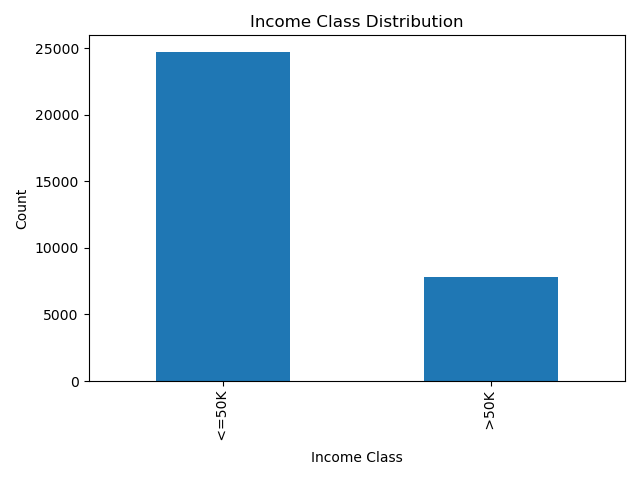

In [ ]:
from IPython.display import Image, display

# We use url here because the item returned from the REPL is a string - we can't save files just yet.
display(Image(url=result.analysis_graphs[0].url))

## Summary

- Use `dspy.DataFrame` as the type annotation for DataFrame input fields
- DataFrames are serialized via Parquet, preserving all dtypes
- Rich metadata (shape, columns, dtypes, samples) is provided to the LLM
- The DataFrame is available in the RLM sandbox for pandas operations
- Works seamlessly with other input types (strings, numbers, etc.)